In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import os
from pandas import json_normalize
from scipy import stats
from scipy.signal import savgol_filter

In [25]:
df = pd.read_csv("C:/Users/user/Desktop/GA4_project/preproccessed_df.csv")

# 시간 단위 컬럼으로 변환
df['utc_time'] = pd.to_datetime(df['utc_time'])

df.head(3)

C:\Users\user\AppData\Local\Temp\ipykernel_7064\477848715.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("C:/Users/user/Desktop/GA4_project/preproccessed_df.csv")


,fullVisitorId,visitStartTime,channelGrouping,continent,subContinent,country,city,visits,pageviews,hits,...,bounces,transactionRevenue,campaign,source,medium,keyword,browser,operatingSystem,deviceCategory,utc_time
0,1131660440785968503,1472830385,Organic Search,Asia,Western Asia,Turkey,Izmir,1,1,1,...,1,0,(not set),google,organic,(not provided),Chrome,Windows,desktop,2016-09-02 15:33:05+00:00
1,377306020877927890,1472880147,Organic Search,Oceania,Australasia,Australia,not available in demo dataset,1,1,1,...,1,0,(not set),google,organic,(not provided),Firefox,Macintosh,desktop,2016-09-03 05:22:27+00:00
2,3895546263509774583,1472865386,Organic Search,Europe,Southern Europe,Spain,Madrid,1,1,1,...,1,0,(not set),google,organic,(not provided),Chrome,Windows,desktop,2016-09-03 01:16:26+00:00


- country 컬럼 중 미국에 해당하는 키 값 조회

In [26]:
df['country'].unique() ## 'United States' 인것을 확인

array(['Turkey', 'Australia', 'Spain', 'Indonesia', 'United Kingdom',
       'Italy', 'Pakistan', 'Austria', 'Netherlands', 'India', 'France',
       'Brazil', 'China', 'Singapore', 'Argentina', 'Poland', 'Germany',
       'Canada', 'Thailand', 'Hungary', 'Malaysia', 'Denmark', 'Taiwan',
       'Russia', 'Nigeria', 'Belgium', 'South Korea', 'Chile', 'Ireland',
       'Philippines', 'Greece', 'Mexico', 'Montenegro', 'United States',
       'Bangladesh', 'Japan', 'Slovenia', 'Czechia', 'Sweden',
       'United Arab Emirates', 'Switzerland', 'Portugal', 'Peru',
       'Hong Kong', 'Vietnam', 'Sri Lanka', 'Serbia', 'Norway', 'Romania',
       'Kenya', 'Ukraine', 'Israel', 'Slovakia', '(not set)', 'Lithuania',
       'Puerto Rico', 'Bosnia & Herzegovina', 'Croatia', 'South Africa',
       'Paraguay', 'Botswana', 'Colombia', 'Uruguay', 'Algeria',
       'Finland', 'Guatemala', 'Egypt', 'Malta', 'Bulgaria',
       'New Zealand', 'Kuwait', 'Uzbekistan', 'Saudi Arabia', 'Cyprus',
       'Estoni

- country 컬럼 값이 'United States' 인 것만을 뽑아 다시 df 에 저장

In [27]:
df = df[df['country'] == 'United States']

df.head(3)

,fullVisitorId,visitStartTime,channelGrouping,continent,subContinent,country,city,visits,pageviews,hits,...,bounces,transactionRevenue,campaign,source,medium,keyword,browser,operatingSystem,deviceCategory,utc_time
67,3746051970600816343,1472843059,Referral,Americas,Northern America,United States,Mountain View,1,1,1,...,1,0,(not set),sites.google.com,referral,(not provided),Chrome,Linux,desktop,2016-09-02 19:04:19+00:00
96,2486407044795377188,1472830426,Referral,Americas,Northern America,United States,not available in demo dataset,1,1,1,...,1,0,(not set),siliconvalley.about.com,referral,(not provided),Chrome,Windows,desktop,2016-09-02 15:33:46+00:00
102,2870162892603227525,1472858877,Paid Search,Americas,Northern America,United States,not available in demo dataset,1,1,1,...,1,0,AW - Dynamic Search Ads Whole Site,google,cpc,6qEhsCssdK0z36ri,Chrome,Android,mobile,2016-09-02 23:27:57+00:00


## 방문 주차별 리텐션 히트맵 시각화

- 6주간의 리텐션만 히트맵을 만드는 것으로 함
- 기록에 남아있는 기간중 가장 방문율이 높았던 기간 6개월을 사용하기로 함 - WAU 확인

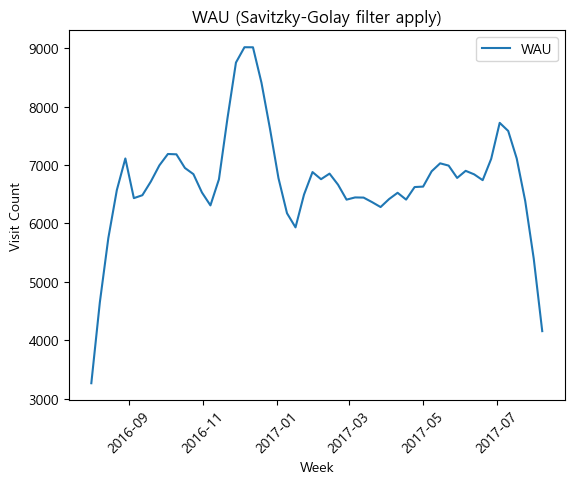

In [28]:
# 'utc_time' 컬럼을 datetime 형식으로 변환
df['utc_time'] = pd.to_datetime(df['utc_time'])

# 'utc_time' 컬럼에서 날짜를 추출하여 새로운 컬럼 추가
df['date'] = df['utc_time'].dt.date

# 주 단위로 데이터 집계
weekly_counts = df.resample('W-Mon', on='utc_time').size()

# Savitzky-Golay 필터 적용
smoothed_weekly_counts = savgol_filter(weekly_counts.values, window_length=10, polyorder=2)

# 선 그래프 그리기
plt.plot(weekly_counts.index, smoothed_weekly_counts, label='WAU')
plt.title('WAU (Savitzky-Golay filter apply)')
plt.xlabel('Week')
plt.ylabel('Visit Count')
plt.xticks(rotation=45)
plt.legend()
plt.show()

- WAU를 보면 2016년 11월과 12월이 가장 많은 접속자가 있었던 기간임을 알 수 있음

- 샘플링한 기간 : 2016년 11월 1일 ~ 2016년 12월 13일

1. 2016년 11월 1일부터 2016년 11월 7일까지의 기간

In [29]:
def make_list_return_user_count(df, start_date, end_date):
    # start_date와 end_date를 datetime 형식으로 변환
    start_date = pd.Timestamp(start_date, tz='UTC')
    end_date = pd.Timestamp(end_date, tz='UTC')

    # 해당 기간 동안 접속한 적이 있는 fullVisitorId 추출
    visited_customers_start = df.loc[(df['utc_time'] >= start_date) & (df['utc_time'] <= end_date), 'fullVisitorId'].unique()

    # 다시 접속한 유저 수를 저장할 리스트
    return_users_count = [len(visited_customers_start)]

    # 기간의 끝을 기준으로 6주간의 기간에 대한 반복
    for i in range(1, 6):
        # 다음 주의 시작과 끝 날짜 계산
        next_week_start = end_date + pd.DateOffset(days=1)
        next_week_end = end_date + pd.DateOffset(days=7)

        # 해당 기간 동안 접속한 적이 있는 fullVisitorId 추출
        visited_customers_next_week = df.loc[(df['utc_time'] >= next_week_start) & (df['utc_time'] <= next_week_end), 'fullVisitorId'].unique()

        # 해당 주에 다시 접속한 유저 수를 리스트에 추가
        return_users_count.append(len(set(visited_customers_start) & set(visited_customers_next_week)))

        # 다음 주를 위해 기간 업데이트
        end_date = next_week_end

    # 6주간의 다시 접속한 유저들의 수 리스트 반환
    return return_users_count

# 함수 확인
_2016_11_01_to_2016_11_07 = make_list_return_user_count(df, '2016-11-01', '2016-11-07')

_2016_11_01_to_2016_11_07


[4387, 293, 202, 130, 162, 127]

- 만든 함수를 이용해 각 주로부터 6주간의 리텐션을 담은 리스트 생성

In [30]:
# 11월 1일부터 7일까지
_2016_11_01_to_2016_11_07 = make_list_return_user_count(df, '2016-11-01', '2016-11-07')
print(_2016_11_01_to_2016_11_07)

# 11월 8일 부터 11월 14일까지
_2016_11_08_to_2016_11_14 = make_list_return_user_count(df, '2016-11-08', '2016-11-14')
print(_2016_11_08_to_2016_11_14)

# 11월 15일 부터 11월 21일까지
_2016_11_15_to_2016_11_21 = make_list_return_user_count(df, '2016-11-15', '2016-11-21')
print(_2016_11_15_to_2016_11_21)

# 11월 22일 부터 11월 28일까지
_2016_11_22_to_2016_11_28 = make_list_return_user_count(df, '2016-11-22', '2016-11-28')
print(_2016_11_22_to_2016_11_28)
      
# 11월 29일 부터 12월 5일까지
_2016_11_29_to_2016_12_05 = make_list_return_user_count(df, '2016-11-29', '2016-12-05')
print(_2016_11_29_to_2016_12_05)

# 12월 6일 부터 12월 12일까지
_2016_12_06_to_2016_12_12 = make_list_return_user_count(df, '2016-12-06', '2016-12-12')
print(_2016_12_06_to_2016_12_12)

[4387, 293, 202, 130, 162, 127]
[4120, 283, 151, 199, 147, 102]
[5008, 290, 275, 214, 162, 87]
[4889, 311, 212, 183, 89, 68]
[6281, 446, 256, 135, 100, 131]
[6990, 438, 202, 132, 148, 86]


- 생성한 리스트를 데이터 프레임으로 변환

In [31]:
# 데이터 프레임 생성 (전치하여 생성)
weekly_retention_data = {
    '11월 01일 ~ 11월 07일': _2016_11_01_to_2016_11_07,
    '11월 08일 ~ 11월 14일': _2016_11_08_to_2016_11_14,
    '11월 15일 ~ 11월 21일': _2016_11_15_to_2016_11_21,
    '11월 22일 ~ 11월 28일': _2016_11_22_to_2016_11_28,
    '11월 29일 ~ 12월 05일': _2016_11_29_to_2016_12_05,
    '12월 06일 ~ 12월 12일': _2016_12_06_to_2016_12_12
}

weekly_retention = pd.DataFrame(weekly_retention_data, index=['0주차', '1주차', '2주차', '3주차', '4주차', '5주차']).T

# 결과 출력
weekly_retention

,0주차,1주차,2주차,3주차,4주차,5주차
11월 01일 ~ 11월 07일,4387,293,202,130,162,127
11월 08일 ~ 11월 14일,4120,283,151,199,147,102
11월 15일 ~ 11월 21일,5008,290,275,214,162,87
11월 22일 ~ 11월 28일,4889,311,212,183,89,68
11월 29일 ~ 12월 05일,6281,446,256,135,100,131
12월 06일 ~ 12월 12일,6990,438,202,132,148,86


- 히트맵 생성

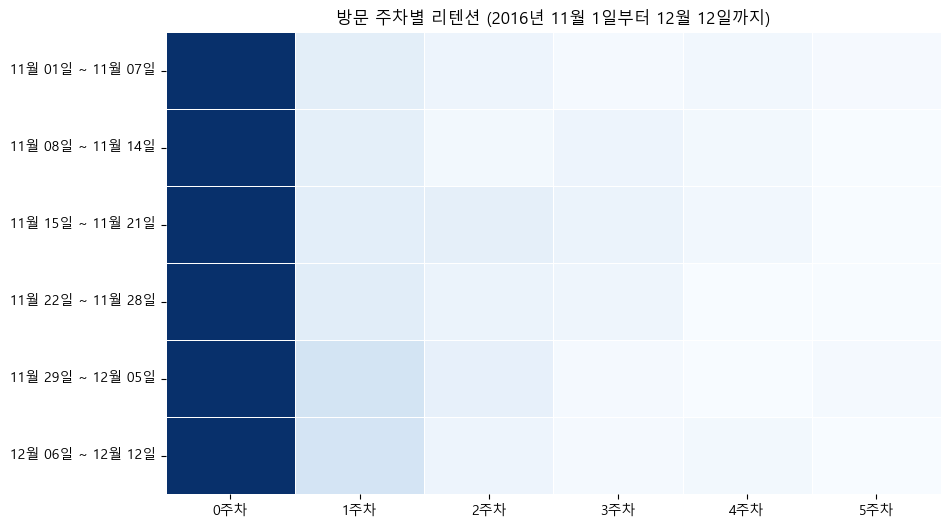

In [32]:
# 한글 안깨지게 방지
# 한글 폰트 설정
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/malgun.ttf"  # 한글 폰트 파일 경로
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

# 히트맵 생성 (Blues 색상 맵 사용)
# 히트맵 생성 (vmin 및 vmax에 숫자 직접 적용)
plt.figure(figsize=(10, 6))
sns.heatmap(weekly_retention, annot=False, cmap='Blues', linewidths=.5, cbar=False, vmin=100, vmax=2000)
plt.title('방문 주차별 리텐션 (2016년 11월 1일부터 12월 12일까지)')

plt.show()

- 2017년 4월 1일 부터 2017년 5월 12일 까지의 데이터를 샘플링해서 리텐션 히트맵으로 만들기

앞서서 만든 함수를 통해 새로 샘플링한 기간의 리텐션 유저 수, 주 별로 리스트로 만들기

In [33]:
# 2017년 4월 1일부터 4월 7일까지
_2017_04_01_to_2017_04_07 = make_list_return_user_count(df, '2017-04-01', '2017-04-07')
print(_2017_04_01_to_2017_04_07)

# 2017년 4월 8일 부터 4월 14일까지
_2017_04_08_to_2017_04_14 = make_list_return_user_count(df, '2017-04-08', '2017-04-14')
print(_2017_04_08_to_2017_04_14)

# 2017년 4월 15일 부터 4월 21일까지
_2017_04_15_to_2017_04_21 = make_list_return_user_count(df, '2017-04-15', '2017-04-21')
print(_2017_04_15_to_2017_04_21)

# 2017년 4월 22일 부터 4월 28일까지
_2017_04_22_to_2017_04_28 = make_list_return_user_count(df, '2017-04-22', '2017-04-28')
print(_2017_04_22_to_2017_04_28)
      
# 2017년 4월 29일 부터 5월 5일까지
_2017_04_29_to_2017_05_05 = make_list_return_user_count(df, '2017-04-29', '2017-05-05')
print(_2017_04_29_to_2017_05_05)

#2017년 5월 6일 부터 5월 12일까지
_2017_05_06_to_2017_05_12 = make_list_return_user_count(df, '2017-05-06', '2017-05-12')
print(_2017_05_06_to_2017_05_12)

[4973, 253, 114, 118, 90, 64]
[4247, 178, 169, 101, 78, 60]
[4317, 171, 110, 84, 66, 64]
[5162, 244, 155, 120, 98, 69]
[5092, 228, 179, 133, 93, 79]
[4040, 199, 171, 99, 93, 85]


- 리스트를 데이터 프레임으로 변환

In [34]:
# 데이터 프레임 생성 (전치하여 생성)
weekly_retention_data_2 = {
    '04월 01일 ~ 04월 07일': _2017_04_01_to_2017_04_07,
    '04월 08일 ~ 04월 14일': _2017_04_08_to_2017_04_14,
    '04월 15일 ~ 04월 21일': _2017_04_15_to_2017_04_21,
    '04월 22일 ~ 04월 28일': _2017_04_22_to_2017_04_28,
    '04월 29일 ~ 05월 05일': _2017_04_29_to_2017_05_05,
    '05월 06일 ~ 05월 12일': _2017_05_06_to_2017_05_12
}

weekly_retention_2 = pd.DataFrame(weekly_retention_data_2, index=['0주차', '1주차', '2주차', '3주차', '4주차', '5주차']).T

# 결과 출력
weekly_retention_2

,0주차,1주차,2주차,3주차,4주차,5주차
04월 01일 ~ 04월 07일,4973,253,114,118,90,64
04월 08일 ~ 04월 14일,4247,178,169,101,78,60
04월 15일 ~ 04월 21일,4317,171,110,84,66,64
04월 22일 ~ 04월 28일,5162,244,155,120,98,69
04월 29일 ~ 05월 05일,5092,228,179,133,93,79
05월 06일 ~ 05월 12일,4040,199,171,99,93,85


- 데이터 프레임으로 히트맵 생성

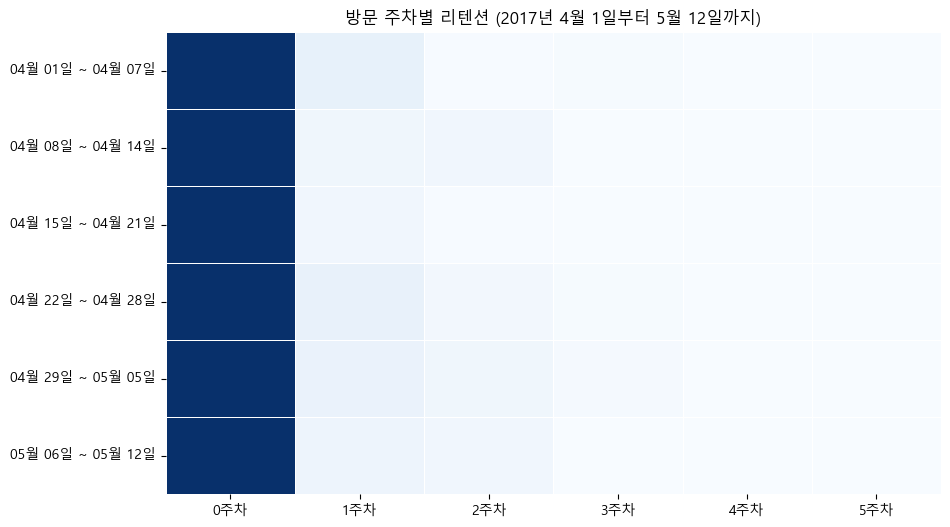

In [40]:
# 한글 안깨지게 방지
# 한글 폰트 설정
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/malgun.ttf"  # 한글 폰트 파일 경로
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

# 히트맵 생성 (Blues 색상 맵 사용)
# 히트맵 생성 (vmin 및 vmax에 숫자 직접 적용)
plt.figure(figsize=(10, 6))
sns.heatmap(weekly_retention_2, annot=False, cmap='Blues', linewidths=.5, cbar=False, vmin=100, vmax=2000)
plt.title('방문 주차별 리텐션 (2017년 4월 1일부터 5월 12일까지)')

plt.show()

In [36]:
## 비교

weekly_retention

,0주차,1주차,2주차,3주차,4주차,5주차
11월 01일 ~ 11월 07일,4387,293,202,130,162,127
11월 08일 ~ 11월 14일,4120,283,151,199,147,102
11월 15일 ~ 11월 21일,5008,290,275,214,162,87
11월 22일 ~ 11월 28일,4889,311,212,183,89,68
11월 29일 ~ 12월 05일,6281,446,256,135,100,131
12월 06일 ~ 12월 12일,6990,438,202,132,148,86


In [37]:
weekly_retention_2

,0주차,1주차,2주차,3주차,4주차,5주차
04월 01일 ~ 04월 07일,4973,253,114,118,90,64
04월 08일 ~ 04월 14일,4247,178,169,101,78,60
04월 15일 ~ 04월 21일,4317,171,110,84,66,64
04월 22일 ~ 04월 28일,5162,244,155,120,98,69
04월 29일 ~ 05월 05일,5092,228,179,133,93,79
05월 06일 ~ 05월 12일,4040,199,171,99,93,85
